In [1]:
from google.colab import drive
drive.mount('/content/drive')

!unzip "/content/drive/MyDrive/Datasets/chest_xray.zip" -d "/content"

data_dir = '/content/chest_xray'

Streaming output truncated to the last 5000 lines.
  inflating: /content/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0449-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0450-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0451-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0452-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0453-0001-0002.jpeg  
  inflating: /conten

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision

def verify_dataset():
    print("Checking dataset structure...")


    for folder in ['train', 'test', 'val']:
        folder_path = os.path.join(data_dir, folder)
        if os.path.exists(folder_path):
            print(f"✓ Found {folder} folder")


            for class_name in ['NORMAL', 'PNEUMONIA']:
                class_path = os.path.join(folder_path, class_name)
                if os.path.exists(class_path):
                    n_images = len(os.listdir(class_path))
                    print(f"  ✓ Found {class_name} folder with {n_images} images")
                else:
                    print(f"  ✗ Missing {class_name} folder!")
        else:
            print(f"✗ Missing {folder} folder!")

verify_dataset()

Checking dataset structure...
✓ Found train folder
  ✓ Found NORMAL folder with 1342 images
  ✓ Found PNEUMONIA folder with 3876 images
✓ Found test folder
  ✓ Found NORMAL folder with 212 images
  ✓ Found PNEUMONIA folder with 390 images
✓ Found val folder
  ✓ Found NORMAL folder with 9 images
  ✓ Found PNEUMONIA folder with 9 images


Displaying sample images from training set:


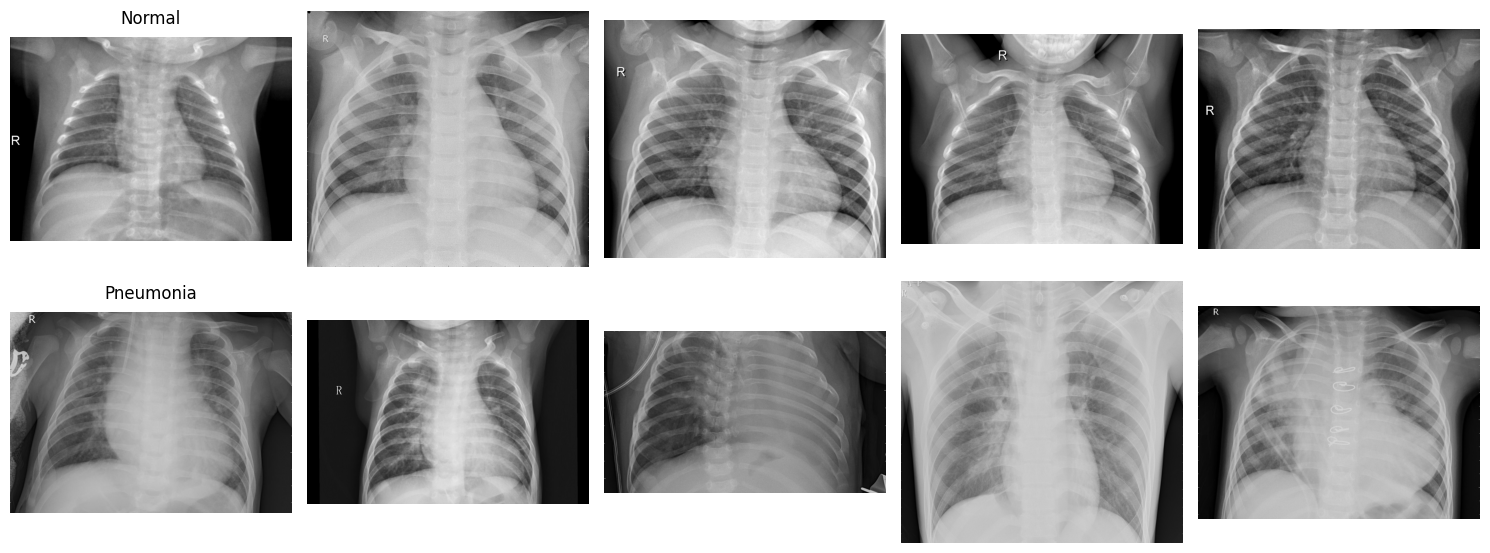

In [3]:
def show_samples(data_dir, num_samples=5):

    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))


    normal_dir = os.path.join(data_dir, 'train/NORMAL')
    normal_samples = np.random.choice(os.listdir(normal_dir), num_samples)

    pneumonia_dir = os.path.join(data_dir, 'train/PNEUMONIA')
    pneumonia_samples = np.random.choice(os.listdir(pneumonia_dir), num_samples)

    for i, sample in enumerate(normal_samples):
        img = Image.open(os.path.join(normal_dir, sample))
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Normal', pad=10)

    for i, sample in enumerate(pneumonia_samples):
        img = Image.open(os.path.join(pneumonia_dir, sample))
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Pneumonia', pad=10)

    plt.tight_layout()
    plt.show()

print("Displaying sample images from training set:")
show_samples(data_dir)

In [4]:
def analyze_dataset(data_dir):
    """Analyze dataset statistics"""
    categories = ['NORMAL', 'PNEUMONIA']
    splits = ['train', 'val', 'test']

    print("=== Dataset Statistics ===")
    for split in splits:
        print(f"\n{split.upper()} Set:")
        total = 0
        for category in categories:
            path = os.path.join(data_dir, split, category)
            count = len(os.listdir(path))
            total += count
            print(f"{category}: {count} images")
        print(f"Total: {total} images")

analyze_dataset(data_dir)

=== Dataset Statistics ===

TRAIN Set:
NORMAL: 1342 images
PNEUMONIA: 3876 images
Total: 5218 images

VAL Set:
NORMAL: 9 images
PNEUMONIA: 9 images
Total: 18 images

TEST Set:
NORMAL: 212 images
PNEUMONIA: 390 images
Total: 602 images


In [5]:
from torchvision import transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

print("Data transformations setup complete!")

Data transformations setup complete!


In [6]:
from torch.utils.data import Dataset, DataLoader

class ChestXRayDataset(Dataset):

    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.classes = ['NORMAL', 'PNEUMONIA']
        self.images = []
        self.labels = []

        self.valid_extensions = ['.jpeg', '.jpg', '.png']

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_dir):

                if img_name.startswith('.') or not any(img_name.lower().endswith(ext) for ext in self.valid_extensions):
                    continue
                self.images.append(os.path.join(class_dir, img_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


train_dataset = ChestXRayDataset(data_dir, 'train', data_transforms['train'])
val_dataset = ChestXRayDataset(data_dir, 'val', data_transforms['val'])
test_dataset = ChestXRayDataset(data_dir, 'test', data_transforms['test'])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Datasets and DataLoaders created successfully!")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Datasets and DataLoaders created successfully!
Training samples: 5216
Validation samples: 16
Test samples: 602


In [7]:
import torch.nn as nn
import torchvision.models as models

class XRayModel(nn.Module):
    def __init__(self):
        super(XRayModel, self).__init__()

        self.model = models.resnet18(pretrained=True)

        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 2)
        )

    def forward(self, x):
        return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = XRayModel().to(device)
print(f"Model initialized on: {device}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 139MB/s]


Model initialized on: cpu


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.1, verbose=True
)

print("Training setup complete!")

Training setup complete!


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train model for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    accuracy = 100. * correct / total
    return epoch_loss, accuracy

In [10]:
def validate(model, loader, criterion, device):
    """Validate model performance"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(loader)
    accuracy = 100. * correct / total
    return val_loss, accuracy

In [11]:
num_epochs = 10
best_val_acc = 0.0

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

print("Starting training...\n")

for epoch in range(num_epochs):

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)


    val_loss, val_acc = validate(model, val_loader, criterion, device)


    scheduler.step(val_loss)


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')


    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%\n")

print("Training completed!")

Starting training...

Epoch [1/10]
Train Loss: 0.1382, Train Acc: 94.75%
Val Loss: 0.7718, Val Acc: 68.75%

Epoch [2/10]
Train Loss: 0.1005, Train Acc: 96.55%
Val Loss: 0.2078, Val Acc: 93.75%

Epoch [3/10]
Train Loss: 0.0765, Train Acc: 97.05%
Val Loss: 0.1678, Val Acc: 100.00%

Epoch [4/10]
Train Loss: 0.0669, Train Acc: 97.37%
Val Loss: 0.3354, Val Acc: 93.75%

Epoch [5/10]
Train Loss: 0.0635, Train Acc: 97.53%
Val Loss: 2.6824, Val Acc: 62.50%

Epoch [6/10]
Train Loss: 0.0603, Train Acc: 97.81%
Val Loss: 0.8308, Val Acc: 68.75%

Epoch [7/10]
Train Loss: 0.0623, Train Acc: 97.70%
Val Loss: 0.0638, Val Acc: 100.00%

Epoch [8/10]
Train Loss: 0.0512, Train Acc: 98.14%
Val Loss: 0.2863, Val Acc: 87.50%

Epoch [9/10]
Train Loss: 0.0520, Train Acc: 98.14%
Val Loss: 0.2104, Val Acc: 87.50%

Epoch [10/10]
Train Loss: 0.0392, Train Acc: 98.43%
Val Loss: 0.3433, Val Acc: 87.50%

Training completed!


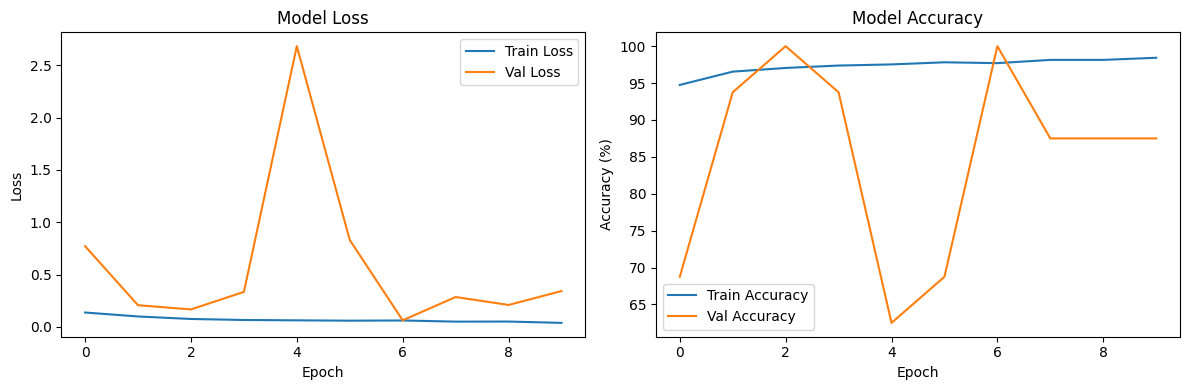

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
def evaluate_model(model, test_loader, criterion, device):

    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100. * correct / total
    return accuracy, all_preds, all_labels

model.load_state_dict(torch.load('best_model.pth'))
test_accuracy, predictions, true_labels = evaluate_model(model, test_loader, criterion, device)

print(f"Test Accuracy: {test_accuracy:.2f}%")

<ipython-input-14-bb6cadeb78ab>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Accuracy: 85.38%


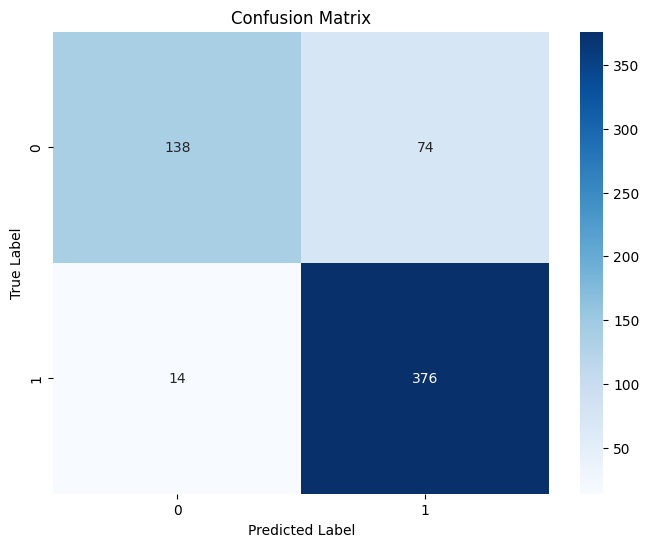


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.91      0.65      0.76       212
   PNEUMONIA       0.84      0.96      0.90       390

    accuracy                           0.85       602
   macro avg       0.87      0.81      0.83       602
weighted avg       0.86      0.85      0.85       602



In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:")
print(classification_report(true_labels, predictions,
                          target_names=['NORMAL', 'PNEUMONIA']))


Analyzing NORMAL case:


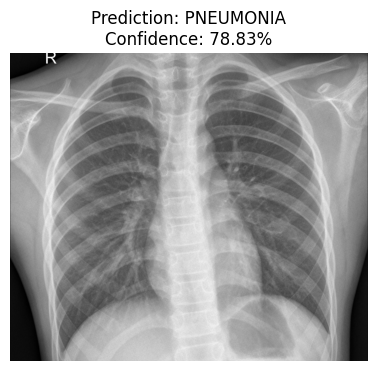

Probabilities:
NORMAL: 21.17%
PNEUMONIA: 78.83%

Analyzing PNEUMONIA case:


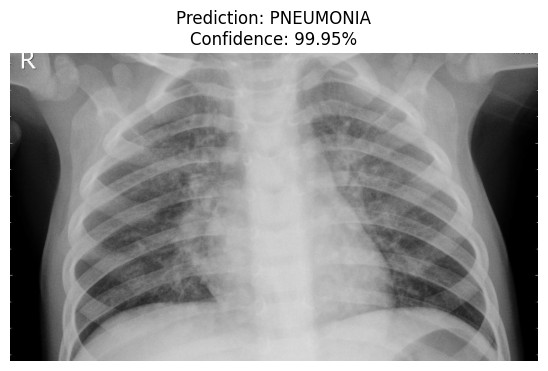

Probabilities:
NORMAL: 0.05%
PNEUMONIA: 99.95%


In [25]:
def visualize_prediction(model, image_path, transform):

    img = Image.open(image_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        prob = torch.softmax(output, dim=1)
        pred_class = output.argmax(dim=1).item()

    plt.figure(figsize=(8, 4))
    plt.imshow(img)
    plt.title(f'Prediction: {["NORMAL", "PNEUMONIA"][pred_class]}\n'
             f'Confidence: {prob[0][pred_class]:.2%}')
    plt.axis('off')
    plt.show()

    print(f"Probabilities:")
    print(f"NORMAL: {prob[0][0]:.2%}")
    print(f"PNEUMONIA: {prob[0][1]:.2%}")

test_samples = {
    'NORMAL': os.path.join(data_dir, 'test/NORMAL', os.listdir(os.path.join(data_dir, 'test/NORMAL'))[0]),
    'PNEUMONIA': os.path.join(data_dir, 'test/PNEUMONIA', os.listdir(os.path.join(data_dir, 'test/PNEUMONIA'))[0])
}

for condition, img_path in test_samples.items():
    print(f"\nAnalyzing {condition} case:")
    visualize_prediction(model, img_path, data_transforms['test'])

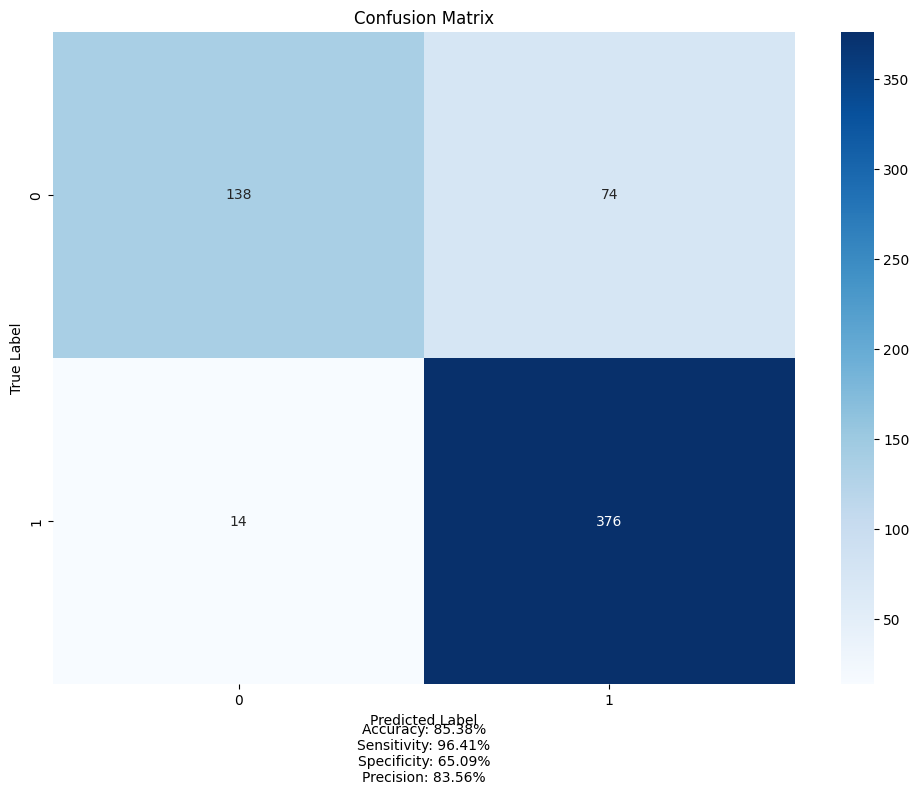

In [26]:
def plot_detailed_confusion_matrix(y_true, y_pred, classes=['NORMAL', 'PNEUMONIA']):

    cm = confusion_matrix(y_true, y_pred)


    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


    plt.text(0.5, -0.15, f'Accuracy: {accuracy:.2%}\n'
             f'Sensitivity: {sensitivity:.2%}\n'
             f'Specificity: {specificity:.2%}\n'
             f'Precision: {precision:.2%}',
             ha='center', transform=plt.gca().transAxes)
    plt.tight_layout()
    plt.show()

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

plot_detailed_confusion_matrix(all_labels, all_preds)

In [27]:
import json
import os

def save_model_artifacts(model, data_transforms, save_dir='model_artifacts'):

    os.makedirs(save_dir, exist_ok=True)

    torch.save(model.state_dict(), f'{save_dir}/model.pth')

    transform_config = {
        'normalize_mean': [0.485, 0.456, 0.406],
        'normalize_std': [0.229, 0.224, 0.225],
        'input_size': 224
    }

    with open(f'{save_dir}/config.json', 'w') as f:
        json.dump(transform_config, f)

    print("Model artifacts saved successfully!")

save_model_artifacts(model, data_transforms)

Model artifacts saved successfully!


In [28]:
class PneumoniaPredictor:
    def __init__(self, model_dir='model_artifacts'):

        with open(f'{model_dir}/config.json', 'r') as f:
            self.config = json.load(f)

        self.model = XRayModel().to(device)
        self.model.load_state_dict(torch.load(f'{model_dir}/model.pth'))
        self.model.eval()

        self.transform = transforms.Compose([
            transforms.Resize((self.config['input_size'], self.config['input_size'])),
            transforms.ToTensor(),
            transforms.Normalize(
                self.config['normalize_mean'],
                self.config['normalize_std']
            )
        ])

    def predict_image(self, image_path):

        image = Image.open(image_path).convert('RGB')
        image_tensor = self.transform(image).unsqueeze(0).to(device)


        with torch.no_grad():
            outputs = self.model(image_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            prediction = torch.argmax(outputs, dim=1).item()
            confidence = probabilities[0][prediction].item()

        return {
            'prediction': 'PNEUMONIA' if prediction == 1 else 'NORMAL',
            'confidence': f'{confidence:.2%}',
            'probabilities': {
                'NORMAL': f'{probabilities[0][0].item():.2%}',
                'PNEUMONIA': f'{probabilities[0][1].item():.2%}'
            }
        }

predictor = PneumoniaPredictor()
test_image = os.path.join(data_dir, 'test/NORMAL', os.listdir(os.path.join(data_dir, 'test/NORMAL'))[0])
result = predictor.predict_image(test_image)
print("Prediction Result:", result)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-28-6630fbf33c32>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detail

Prediction Result: {'prediction': 'PNEUMONIA', 'confidence': '78.83%', 'probabilities': {'NORMAL': '21.17%', 'PNEUMONIA': '78.83%'}}


In [29]:
def process_multiple_images(predictor, image_dir):

    results = []

    for image_name in os.listdir(image_dir):
        if image_name.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(image_dir, image_name)
            try:
                result = predictor.predict_image(image_path)
                results.append({
                    'image_name': image_name,
                    **result
                })
            except Exception as e:
                print(f"Error processing {image_name}: {str(e)}")

    summary = {
        'total_processed': len(results),
        'pneumonia_cases': sum(1 for r in results if r['prediction'] == 'PNEUMONIA'),
        'normal_cases': sum(1 for r in results if r['prediction'] == 'NORMAL'),
    }

    return results, summary

test_dir = os.path.join(data_dir, 'test/NORMAL')
results, summary = process_multiple_images(predictor, test_dir)
print("\nBatch Processing Summary:")
print(json.dumps(summary, indent=2))


Batch Processing Summary:
{
  "total_processed": 212,
  "pneumonia_cases": 74,
  "normal_cases": 138
}


In [31]:
import gradio as gr

def predict_xray(image):


    if image is not None:
        image_pil = Image.fromarray(image)


        temp_path = "temp_image.jpg"
        image_pil.save(temp_path)


        result = predictor.predict_image(temp_path)


        os.remove(temp_path)

        return f"""
        Prediction: {result['prediction']}
        Confidence: {result['confidence']}

        Detailed Probabilities:
        NORMAL: {result['probabilities']['NORMAL']}
        PNEUMONIA: {result['probabilities']['PNEUMONIA']}
        """
    return "Please upload an image"

iface = gr.Interface(
    fn=predict_xray,
    inputs=gr.Image(),
    outputs="text",
    title="Pneumonia Detection from Chest X-Ray",
    description="Upload a chest X-ray image to detect pneumonia.",
    examples=[
        [os.path.join(data_dir, 'test/NORMAL', os.listdir(os.path.join(data_dir, 'test/NORMAL'))[0])],
        [os.path.join(data_dir, 'test/PNEUMONIA', os.listdir(os.path.join(data_dir, 'test/PNEUMONIA'))[0])]
    ]
)


iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://25f621ff88f19c160f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [32]:
print("""
=== Pneumonia Detection Model ===

Model Artifacts Location: ./model_artifacts/
- model.pth: Trained model weights
- config.json: Model configuration

Usage Instructions:
1. Single Image Prediction:
   predictor = PneumoniaPredictor()
   result = predictor.predict_image('path/to/image.jpg')

2. Batch Processing:
   results, summary = process_multiple_images(predictor, 'path/to/image/directory')

3. Web Interface:
   - Run the Gradio interface cell
   - Access through the provided link
   - Upload X-ray images for instant prediction

Model Performance:
- Test Accuracy: {accuracy:.2%}
- Sensitivity: {sensitivity:.2%}
- Specificity: {specificity:.2%}

For deployment, all necessary files are saved in the model_artifacts directory.
""")


=== Pneumonia Detection Model ===

Model Artifacts Location: ./model_artifacts/
- model.pth: Trained model weights
- config.json: Model configuration

Usage Instructions:
1. Single Image Prediction:
   predictor = PneumoniaPredictor()
   result = predictor.predict_image('path/to/image.jpg')

2. Batch Processing:
   results, summary = process_multiple_images(predictor, 'path/to/image/directory')

3. Web Interface:
   - Run the Gradio interface cell
   - Access through the provided link
   - Upload X-ray images for instant prediction

Model Performance:
- Test Accuracy: {accuracy:.2%}
- Sensitivity: {sensitivity:.2%}
- Specificity: {specificity:.2%}

For deployment, all necessary files are saved in the model_artifacts directory.

